In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier # type: ignore
from xgboost import XGBClassifier
sns.set_style("dark")

import matplotlib.pyplot as plt
%matplotlib inline

### Data Content

- Loan_id : A unique loan number assigned to each loan customers
- Loan_status : Whether a loan is paid off, in collection, new customer yet to payoff, or paid off after the collection efforts
- Principal : Basic principal loan amount at the origination
- terms : Can be weekly (7 days), biweekly, and monthly payoff schedule
- Effective_date : When the loan got originated and took effects
- Due_date : Since it’s one-time payoff schedule, each loan has one single due date
- Paidoff_time : The actual time a customer pays off the loan
- Pastdue_days : How many days a loan has been past due
- Age, education, gender : A customer’s basic demographic information

In [4]:
# Read in the CSV file using pandas, specifying the header row and delimiter
loan_df = pd.read_csv(r'Loan_payments_data.csv')
loan_df.head(2)

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female


In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Loan_ID         500 non-null    object 
 1   loan_status     500 non-null    object 
 2   Principal       500 non-null    int64  
 3   terms           500 non-null    int64  
 4   effective_date  500 non-null    object 
 5   due_date        500 non-null    object 
 6   paid_off_time   400 non-null    object 
 7   past_due_days   200 non-null    float64
 8   age             500 non-null    int64  
 9   education       500 non-null    object 
 10  Gender          500 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 43.1+ KB


In [6]:
# Get the count of missing values (NaN) and divide it by the total number of rows, then multiply by 100 for percentages
na_count = loan_df.isna().sum()
percentage_of_missing_values = (na_count / len(loan_df)) * 100
print(f"Missing values percentage: \n{percentage_of_missing_values}%")

Missing values percentage: 
Loan_ID            0.0
loan_status        0.0
Principal          0.0
terms              0.0
effective_date     0.0
due_date           0.0
paid_off_time     20.0
past_due_days     60.0
age                0.0
education          0.0
Gender             0.0
dtype: float64%


Here we can see that the feature 'past_due_days' has 60% of it's values missing, this is due to the fact that if a loan_status is paid off, it means that in this dataset the loanee paid off the loan prior to ever being in a state of collection; because of this we should replace the NaN values with 0 to reflect that they're all 0 days past their due date. As for paid_off_time, given that these values are null because the loanee has yet to pay off their debt. It seems fitting to create a binary indicator column to highlight it is unpaid and then fill the remaining NaNs with 0.

#### Fill NaN Values, Drop Uneccessary Columns & Format Column Values to Appropriate Format

In [7]:

# Create a binary indicator column for missing paid_off_time
loan_df['paid_off_indicator'] = loan_df['paid_off_time'].notna().astype(int)

# Create date/time columns
for column in ['effective_date', 'due_date', 'paid_off_time']:
    loan_df[column] = pd.to_datetime(loan_df[column])

# Create new columns for day and week
loan_df['paid_off_day'] = loan_df['paid_off_time'].dt.day.fillna(0).astype(int)
loan_df['paid_off_month'] = loan_df['paid_off_time'].apply(lambda x: x.month if pd.notnull(x) else 0).astype(int)

# Replace effective date with effective day
loan_df['effective_day'] = loan_df['effective_date'].apply(lambda x: x.day)
    
# Replace due date with due day and month
loan_df['due_month'] = loan_df['due_date'].apply(lambda x: x.month)
loan_df['due_day'] = loan_df['due_date'].apply(lambda x: x.day)

# For the past due days column, replace the NaN values with 0 to represent that they're 0 days past their due date
loan_df['past_due_days'] = loan_df['past_due_days'].fillna(0).astype(int)

# Drop unecessary columns
loan_df = loan_df.drop(['paid_off_time','effective_date','due_date','Loan_ID'], axis=1)


# Fix issue where some of the data is incorrectly assigned as paidoff rather than collection paid
loan_df.loc[(loan_df.loan_status == 'PAIDOFF') & (loan_df.paid_off_day > 30), 'loan_status'] = 'COLLECTION_PAIDOFF'

# Encode the label (loan_status) column
label_mapping = {'PAIDOFF': 1, 'COLLECTION_PAIDOFF': 1, 'COLLECTION': 0}
loan_df['loan_status'] = loan_df['loan_status'].replace(label_mapping).astype(int)

# loan_df['Gender'] = loan_df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

C:\Users\tyler\AppData\Local\Temp\ipykernel_11452\4046967963.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  loan_df['loan_status'] = loan_df['loan_status'].replace(label_mapping).astype(int)


In [8]:
loan_df.describe()

,loan_status,Principal,terms,past_due_days,age,paid_off_indicator,paid_off_day,paid_off_month,effective_day,due_month,due_day
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.800000,943.200000,22.824000,14.404000,31.116000,0.800000,13.768000,7.680000,11.410000,9.622000,16.642000
std,0.400401,115.240274,8.000064,25.614312,6.084784,0.400401,9.769394,3.887393,1.091918,0.569002,7.406453
min,0.000000,300.000000,7.000000,0.000000,18.000000,0.000000,0.000000,0.000000,8.000000,9.000000,7.000000
25%,1.000000,1000.000000,15.000000,0.000000,27.000000,1.000000,7.000000,9.000000,11.000000,9.000000,10.000000
50%,1.000000,1000.000000,30.000000,0.000000,30.000000,1.000000,12.000000,9.000000,11.000000,10.000000,11.500000
75%,1.000000,1000.000000,30.000000,12.000000,35.000000,1.000000,24.000000,10.000000,12.000000,10.000000,25.000000
max,1.000000,1000.000000,30.000000,76.000000,51.000000,1.000000,31.000000,12.000000,14.000000,11.000000,28.000000


We can see that when it comes to the loan amount (principal) at the 25th percentile to the max all values are at 1,000. Meaning the majority of loans are valued at 1,000. We can also see that the average age of a loanee is 31 years old. 

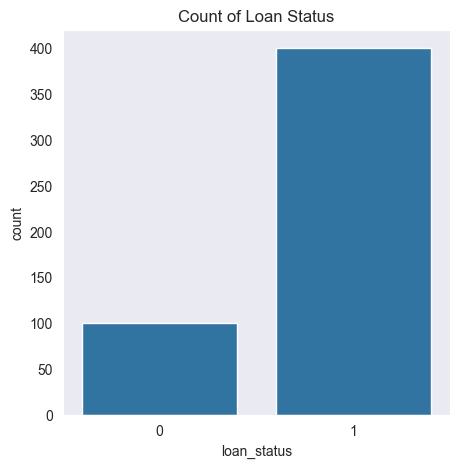

In [9]:
# Create a count plot for the values in the 'loan_status' column
plt.figure(figsize=(5, 5))
sns.countplot(x='loan_status', data=loan_df)

# Set title for the plot
plt.title("Count of Loan Status")

plt.show()

### Get value counts for each column (if it's categorical)
for col in loan_df.select_dtypes(include=['object']).columns:
    print(f'Value count for column "{col}":')
    print(loan_df[col].value_counts(), '\n---')

In [10]:
# Check the unique values for each column
{column: len(loan_df[column].unique()) for column in loan_df.columns}

{'loan_status': 2,
 'Principal': 6,
 'terms': 3,
 'past_due_days': 34,
 'age': 33,
 'education': 4,
 'Gender': 2,
 'paid_off_indicator': 2,
 'paid_off_day': 32,
 'paid_off_month': 5,
 'effective_day': 7,
 'due_month': 3,
 'due_day': 19}

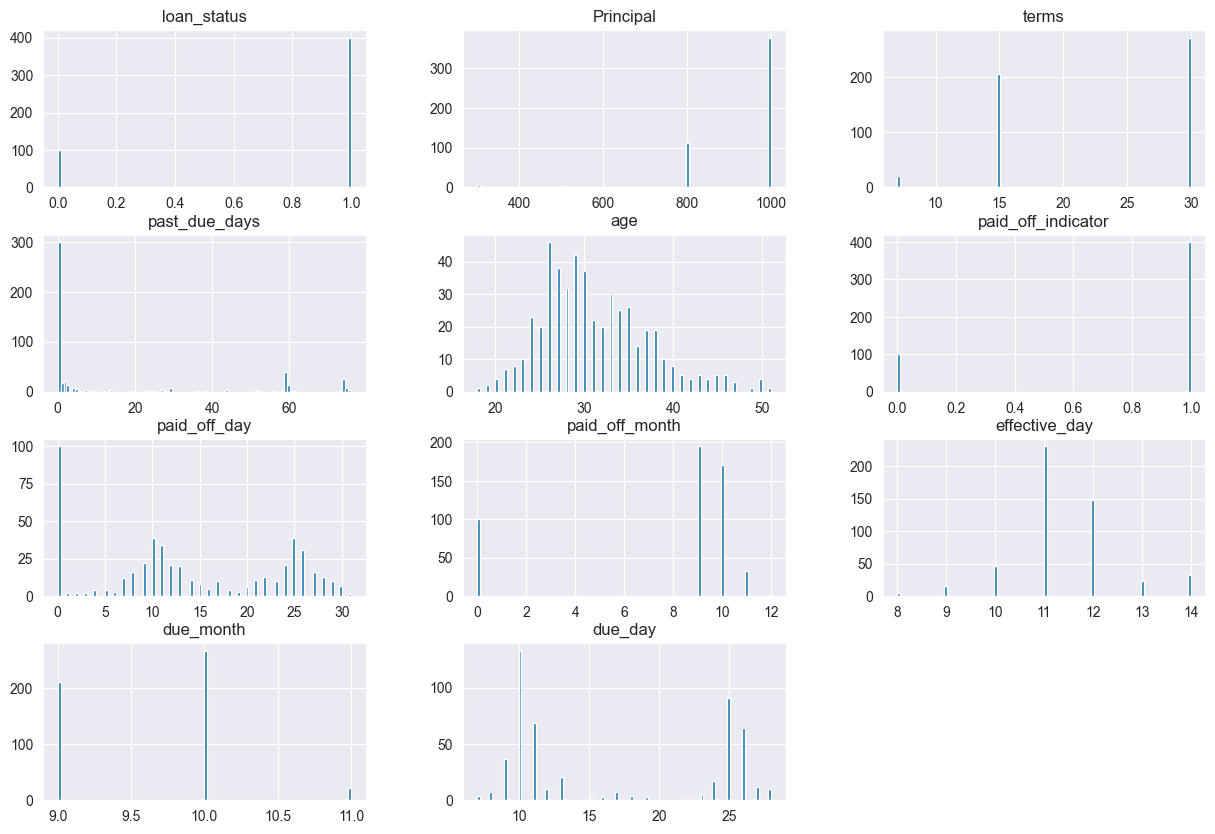

In [11]:
loan_df.hist(bins=100,figsize=(15,10))
plt.show()

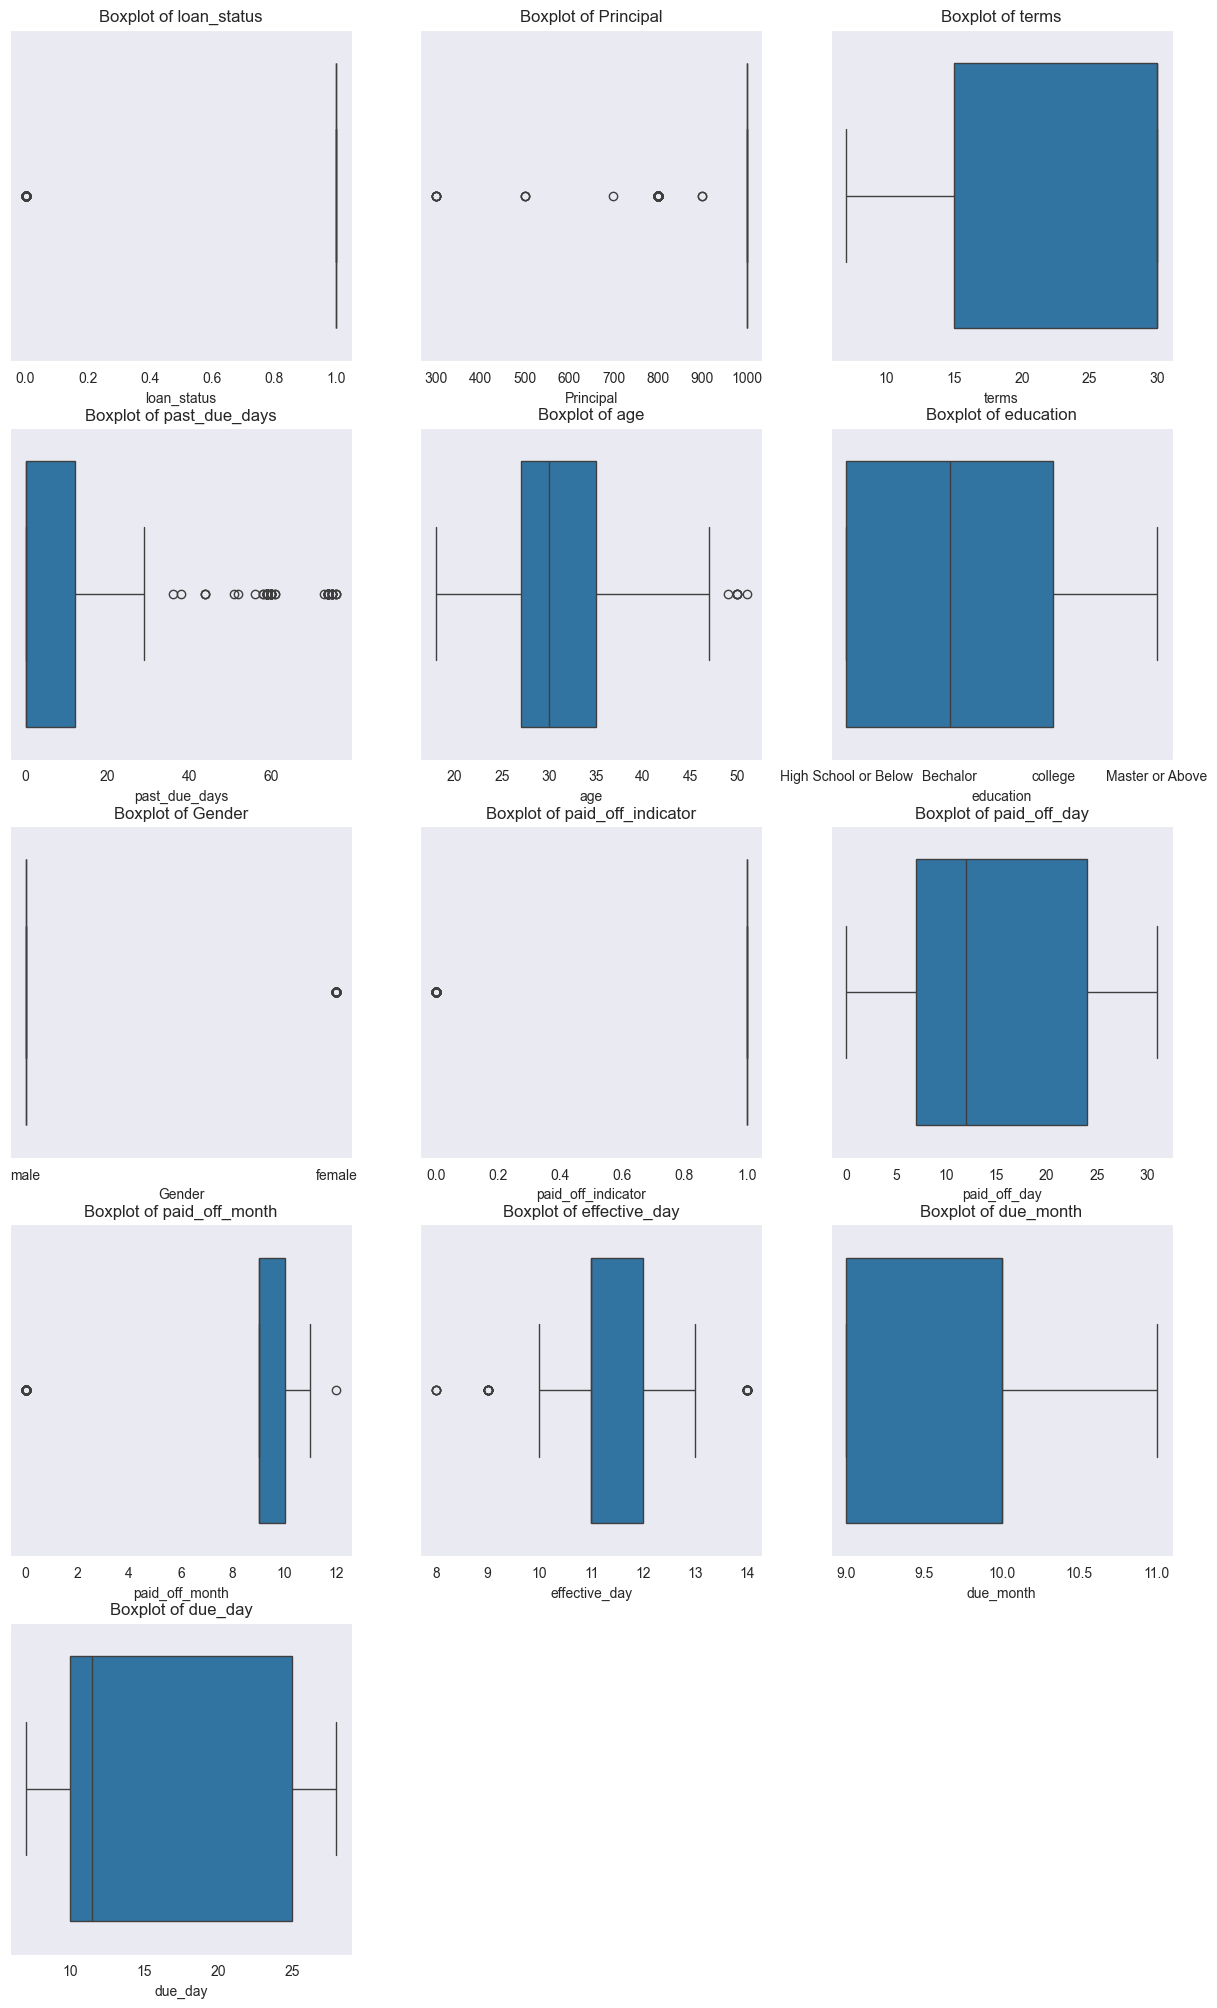

In [12]:
# Number of columns for the subplot grid
num_columns = 3

# Calculate the number of rows needed
num_rows = -(-len(loan_df.columns) // num_columns)  # This is a trick to round up the division

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column and create a boxplot
for i, column in enumerate(loan_df.columns):
    sns.boxplot(data=loan_df, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
# plt.tight_layout()
# plt.show()

#### Encoding and Scaling/Normalising

In [13]:
# Define the education categories in the desired order
education_categories = ['High School or Below', 'college', 'Bechalor', 'Master or Above']
# Create the OrdinalEncoder with the specified categories
ordinal_encoder = OrdinalEncoder(categories=[education_categories])
# Reshape the 'education' column to be a 2D array and fit_transform it
loan_df['education'] = ordinal_encoder.fit_transform(loan_df[['education']])

In [14]:
# Identify numeric columns to scale
numeric_columns = loan_df.select_dtypes(include=['int32', 'int64', 'float64']).columns
# Optionally, exclude columns that   should not be scaled, such as the target variable
columns_to_exclude = ['loan_status']  # For example, exclude the target variable
columns_to_scale = [col for col in numeric_columns if col not in columns_to_exclude]

# Scale the columns
scaler = StandardScaler()
loan_df[columns_to_scale] = scaler.fit_transform(loan_df[columns_to_scale])

In [15]:
#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Apply one-hot encoding to the 'Gender' column
encoded_gender = encoder.fit_transform(loan_df[['Gender']])
# Replace the 'Gender' column with the one-hot encoded values
loan_df = pd.concat([loan_df.drop(columns=['Gender']), pd.DataFrame(encoded_gender, columns=encoder.categories_[0])], axis=1)

# Split df into X and y
y = loan_df['loan_status'].copy()
X = loan_df.drop('loan_status', axis=1).copy()

In [16]:
X.head()

,Principal,terms,past_due_days,age,education,paid_off_indicator,paid_off_day,paid_off_month,effective_day,due_month,due_day,female,male
0,0.493377,0.897891,-0.562905,2.284043,-1.022825,0.5,0.023771,0.339899,-3.126073,0.664986,-1.303142,0.0,1.0
1,0.493377,0.897891,-0.562905,3.106587,1.771779,0.5,-0.693470,0.597399,-3.126073,0.664986,-1.303142,1.0,0.0
2,0.493377,0.897891,-0.562905,0.309935,1.771779,0.5,1.150865,0.339899,-3.126073,0.664986,-1.303142,1.0,0.0
3,0.493377,-0.978972,-0.562905,-0.677119,0.374477,0.5,0.843475,0.339899,-3.126073,-1.094236,0.724148,0.0,1.0
4,0.493377,0.897891,-0.562905,-0.512610,0.374477,0.5,0.945939,0.339899,-2.209336,0.664986,-1.167989,1.0,0.0


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=123)

models = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

for model in models:
    model.fit(X_train, y_train)

model_names = [
    "   Logistic Regression",
    "Support Vector Machine",
    "         Decision Tree",
    "        Neural Network",
    "         Random Forest",
    "               XGBoost"
]

for model, name in zip(models, model_names):
    print(name + ": {:.4f}%".format(model.score(X_test, y_test) * 100))

c:\Users\tyler\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


   Logistic Regression: 100.0000%
Support Vector Machine: 100.0000%
         Decision Tree: 100.0000%
        Neural Network: 100.0000%
         Random Forest: 100.0000%
               XGBoost: 100.0000%
